# Policy iteration DP - Jack's Car Rental

This is exercice 4.2 from the book "Reinforcement Learning: an itroduction. From Sutton and Barto. The problem is extracted from the book as following:

___

Jack manages two locations for a nationwide car rental company.
Each day, some number of customers arrive at each location to rent cars. If Jack has a car available, he
rents it out and is credited \$10 by the national company. If he is out of cars at that location, then the
business is lost. Cars become available for renting the day after they are returned. To help ensure that
cars are available where they are needed, Jack can move them between the two locations overnight, at
a cost of $2 per car moved. We assume that the number of cars requested and returned at each location
are Poisson random variables, meaning that the probability that the number is n is λn e−λ, where λ is n!
the expected number. Suppose λ is 3 and 4 for rental requests at the first and second locations and 3 and 2 for returns. To simplify the problem slightly, we assume that there can be no more than 20 cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem) and a maximum of five cars can be moved from one location to the other in one night. We take the discount rate to be γ = 0.9 and formulate this as a continuing finite MDP, where the time steps are days, the state is the number of cars at each location at the end of the day, and the actions are the net numbers of cars moved between the two locations overnight.

Write a program for policy iteration and re-solve Jack’s car rental problem with the following changes. One of Jack’s employees at the first location rides a bus home each night and lives near the second location. She is happy to shuttle one car to the second location for free. Each additional car still costs \$2, as do all cars moved in the other direction. In addition, Jack has limited parking space at each location. If more than 10 cars are kept overnight at a location (after any moving of cars), then an additional cost of \$4 must be incurred to use a second parking lot (independent of how many cars are kept there). These sorts of nonlinearities and arbitrary dynamics often occur in real problems and cannot easily be handled by optimization methods other than dynamic programming. To check your program, first replicate the results given for the original problem. If your computer is too slow for the full problem, cut all the numbers of cars in half.

___

Policy iteration is a dynamic programming algorithm that is used to find the optimal policy for a finite Markov Decision Problem (MDP). For more information about MDPs check the Gambler's Problem discussion on value iteration.

Policy iteration also uses the Bellman equation as an update rule, but instead of doing it while taking the value of the action that maximizes the long term value at each step, we separate this process in two subprocesses called Policy Evaluation and Policy Improvement.

Recall that the MDP uses the following information:
* S: set of states, s.
* A(s): set of possible actions, a, at state s.
* R: set of possible rewards, r.
* &pi(a|s): the policy. Probability of selecting action a at state s.
* &gamma;: discounting factor to ensure convergence.
* V(s): set that contains the value of each state.
* Q(a,s): set that contains the value of each state given that we take a specific action.

### Policy Evaluation

Using again the Bellman equation we can update each state during each iteration as:

$$v_{k+1}(s) = \sum_{a}\pi(a\mid s)\sum_{s', r} p(s',r \mid s,a)[r +\gamma V_{k}(s')] \forall s \in S$$

Where π is the first policy evaluation we will start with an arbitrary policy, just for the sake of building a representative V(S). But if we have some prior information about the values we can incorporate it for faster convergence. Note also that if the policy is deterministic, the term can be ignored.

At each iteartion and for each state, each value is calculated from the old successor ones plus the immediate reward times the probability of encountering the specifics action, state and next state. This is added up for all possible triplets. As this is not the real value (the policy is abitrary) we call this the expected value of the state, and we will improve it each time we call the policy evaluation after upgrading the policy, making it converge into the real state value.

### Policy Improvement

As our policy starts being arbitrary or having some prior knowledge at most, we want to improve it. What we can do is now that the policy has been evaluated (estimated) we can check whether our policy takes the correct step at each iteration according to the state of values V. In those cases in which:
$$best\_action(s) \neq \pi(s)  $$
we will update π(s) to be the best action.

Formally speaking:

$$\pi'(s) = arg\max_a q_\pi(s,a)$$

$$\pi'(s) =  arg\max_a E_{\pi}[R_{t+1} + \gamma v_\pi(S_{t+1})\mid S_t = s, A_t = a] $$

$$ \pi'(s) = arg\max_a\sum_{s',r} p(s', r \mid s,a)[r + \gamma v_\pi(s')]$$

If we have an evaluated policy, taking the greedy action that maximes the expected value (do not confuse with reward) ensures that the policy is at least equal but probably better than the previous one. In the limit, the policy will be optimal for the specific value state.

### Policy iteration

Once the policy as been improved for the current state-value set, we can recompute (re-evaluate) the policy repeating the policy evaluation and improve it once more. Each repetition of the loop monotonically improves the policy. Given the fact that a finite MDP has a fixed maximum number of different policies, when time reaches infinite, the policy is guaranteed to be the optimal one. Luckily, it gets the optimal policy within few iterations. 

___ 

Following there is a simple implementation of the algorithm for the Jack's Car Rental Prolem. Note that the space dimension of this problem is somehow big. And because each state has a lot of possibble actions, the amount of computation it needs is considerable (that's why the author suggests reducing the data to half if it is too slow). Luckily we can use some heuristics to avoid checking unnecessary state-actions combinations that we know for sure are not important. They are explained in the code.

In [1]:
import numpy
from scipy.stats.distributions import poisson
import pandas
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def initialization(states_shape):
    """
    Initialize the value states V, the policy pi and the actions A.
    V and pi are set to the arbitrary set of all zeroes. 
    - states_shape: shape of the value-state set.
    """
    V = numpy.zeros(states_shape)
    pi = numpy.zeros(states_shape,dtype=numpy.int8)
    A = numpy.arange(-5, 6)
    return V, pi,A

In [3]:
def compute_probabiblities_all(picklambdax = 3, picklambday = 4, returnlambdax = 3, returnlambday = 2):
    """
    Computes all the necessary poission distributed values so they don't have to be calculated several
    times during the policy iteration. The arguments are the specifications of the problem in terms of 
    the values needed for computing the poisson distributions.
    """
    probabilitiesx = numpy.zeros([21, 21])
    probabilitiesy = numpy.zeros([21, 21])
    for picks in range(0, 21):
        for returns in range(0, 21):
            probabilitiesx[picks, returns] += round(poisson.pmf(picks, picklambdax)*poisson.pmf(returns, returnlambdax), 3)
            probabilitiesy[picks, returns] += round(poisson.pmf(picks, picklambday)*poisson.pmf(returns, returnlambday), 3)
    return probabilitiesx, probabilitiesy

In [4]:
def compute_reward(statex, statey, nclientsx, nclientsy, action):
    """
    Computes the reward for every state s, next state s' and action triplet.
    Every rental yields 10 units. Moving a car from place to palce costs 2 
    units, except for the first one which is free. 
    Having more than 10 cars in the same place requires a fee of 4 units.
    """
    rentalsx = min(nclientsx, statex)
    rentalsy = min(nclientsy, statey)
    reward = 10*(rentalsx + rentalsy)
    if action != 0:
        reward -=  2 * (abs(action) - 1)
    if statex > 10:
        reward -= 4
    if statey > 10:
        reward -= 4
    return reward

In [5]:
def policy_evaluation(V, pi, probabilitiesx, probabilitiesy,gamma = 0.9, sigma = 1, max_lambda = 12):
    """
    Computes the policy evaluation step. It takes a as parameters:
    -V :set of arbitrary (or previous) values-state.
    -pi : arbitrary (or previous) policy
    - probabilitiesx and probabilitiesy: set of pre-computed poission distributed probabiblities for
    each parking lot. They are precomputed because doing it more than necessary uses a lot of resources.
    - gamma: the discounting factor to ensure convergence.
    - sigma: the maximum difference between any pair of new-old state to accept convergence.
    - max_lambda: the ammount of maximum value to expect from the poission distribution. To avoid unnecessary
    calculations. Plainly speaking: it is higly improbable that with a k = 3 we could reach a 10. So we 
    can avoid considering them.
    """
    while True:
        delta = 0 #Used to compare with sigma.
        i = 0
        for statex in range(0,21):
            for statey in range(0,21):
                i+= 1
                print('\r' + str(round(i/441*100,3)) + '% of policy evaluation', end = '')
                action = pi[statex, statey]
                V0 = V[statex, statey]
                V[statex, statey] = compute_bellman_update(statex,statey,action,probabilitiesx, probabilitiesy,max_lambda, gamma)
                delta = max(delta, abs(V[statex, statey] - V0))
        print('\n delta score is: ',delta)
        if delta > sigma:
            print('Delta is not small enought, repeating the policy evaluation')
            continue
        else:
            return V    

In [6]:
def policy_improvement(V, pi,A, probabilitiesx, probabilitiesy, max_lambda, gamma):
    """
    Computes the policy improvement step. For each state, it calculates the action
    that maximizes the next value.
    """
    policy_stable = True
    i = 0
    for statex in range(21):
        for statey in range(21):
            i+= 1
            print('\r' + str(round(i/441*100,3)) + '% of policy improvement', end = '')
            old_action = pi[statex, statey]
            pi[statex, statey] = compute_maxaV(V,A,statex, statey,probabilitiesx, probabilitiesy, max_lambda, gamma)
            if old_action != pi[statex, statey]:
                policy_stable = False # Means we modified the policy. So it is not stable yet.
    if policy_stable:
        print('Policy improvement finished. The policy is stable')
    else:
        print('Policy improvement finished. The policy is NOT stable')
    return pi, policy_stable

In [7]:
def compute_maxaV(V,A, statex, statey,probabilitiesx, probabilitiesy, max_lambda, gamma):
    """
    Function used in the policy improvement step. It returns the best action according to the
    value of the future possible stats and the action.
    """
    max_a = 0
    max_q = 0
    for action in A:
        if statex + action < 0:
            continue
        elif statey - action < 0:
            continue
        qva = compute_bellman_update(statex, statey, action, probabilitiesx, probabilitiesy, max_lambda, gamma) 
        if qva > max_q:
            max_q = qva
            max_a = action
    return max_a

In [8]:
def compute_bellman_update(statex,statey,action,probabilitiesx, probabilitiesy,max_lambda, gamma):
    """
    Computes the value of a state using the Bellman equation as update rule. 
    All the parameters are described above.
    """
    v = 0
    statex += action
    statey -= action
    for picksx in range(min(max_lambda,statex+1)):
        for picksy in range(min(max_lambda,statey+1)):
            for returnsx in range(max_lambda):
                for returnsy in range(max_lambda):
                    statex1 = min(max((statex+picksx), 20)-returnsx,0)
                    statey1 = min(max((statey+picksy), 20)-returnsy, 0)
                    reward = compute_reward(statex, statey, picksx, picksy, action) 
                    v += probabilitiesx[picksx, returnsy]*probabilitiesy[picksy, returnsy] * (reward + gamma * V[statex1, statey1])
    return v

With these previous functions we can compute the policy iteartion process. To solve the exercice we could do as below. Nota that even with the optimizations it will take quite some time depending on the computer.

In [9]:
V, pi, A = initialization([21,21])
probabilitiesx, probabilitiesy = compute_probabiblities_all()
V = policy_evaluation(V, pi, probabilitiesx, probabilitiesy, max_lambda=20)
pi, policy_stable = policy_improvement(V, pi, A, probabilitiesx, probabilitiesy, 12,0.9)
while not policy_stable:
    V = policy_evaluation(V, pi, probabilitiesx, probabilitiesy, max_lambda=20)
    pi, policy_stable = policy_improvement(V, pi, A, probabilitiesx, probabilitiesy, 12,0.9)

100.0% of policy evaluationn
 delta score is:  230.9661999999965
Delta is not small enought, repeating the policy evaluation
100.0% of policy evaluationn
 delta score is:  0
100.0% of policy improvementtPolicy improvement finished. The policy is NOT stable
100.0% of policy evaluationn
 delta score is:  171.8976799999994
Delta is not small enought, repeating the policy evaluation
100.0% of policy evaluationn
 delta score is:  0
100.0% of policy improvementtPolicy improvement finished. The policy is stable


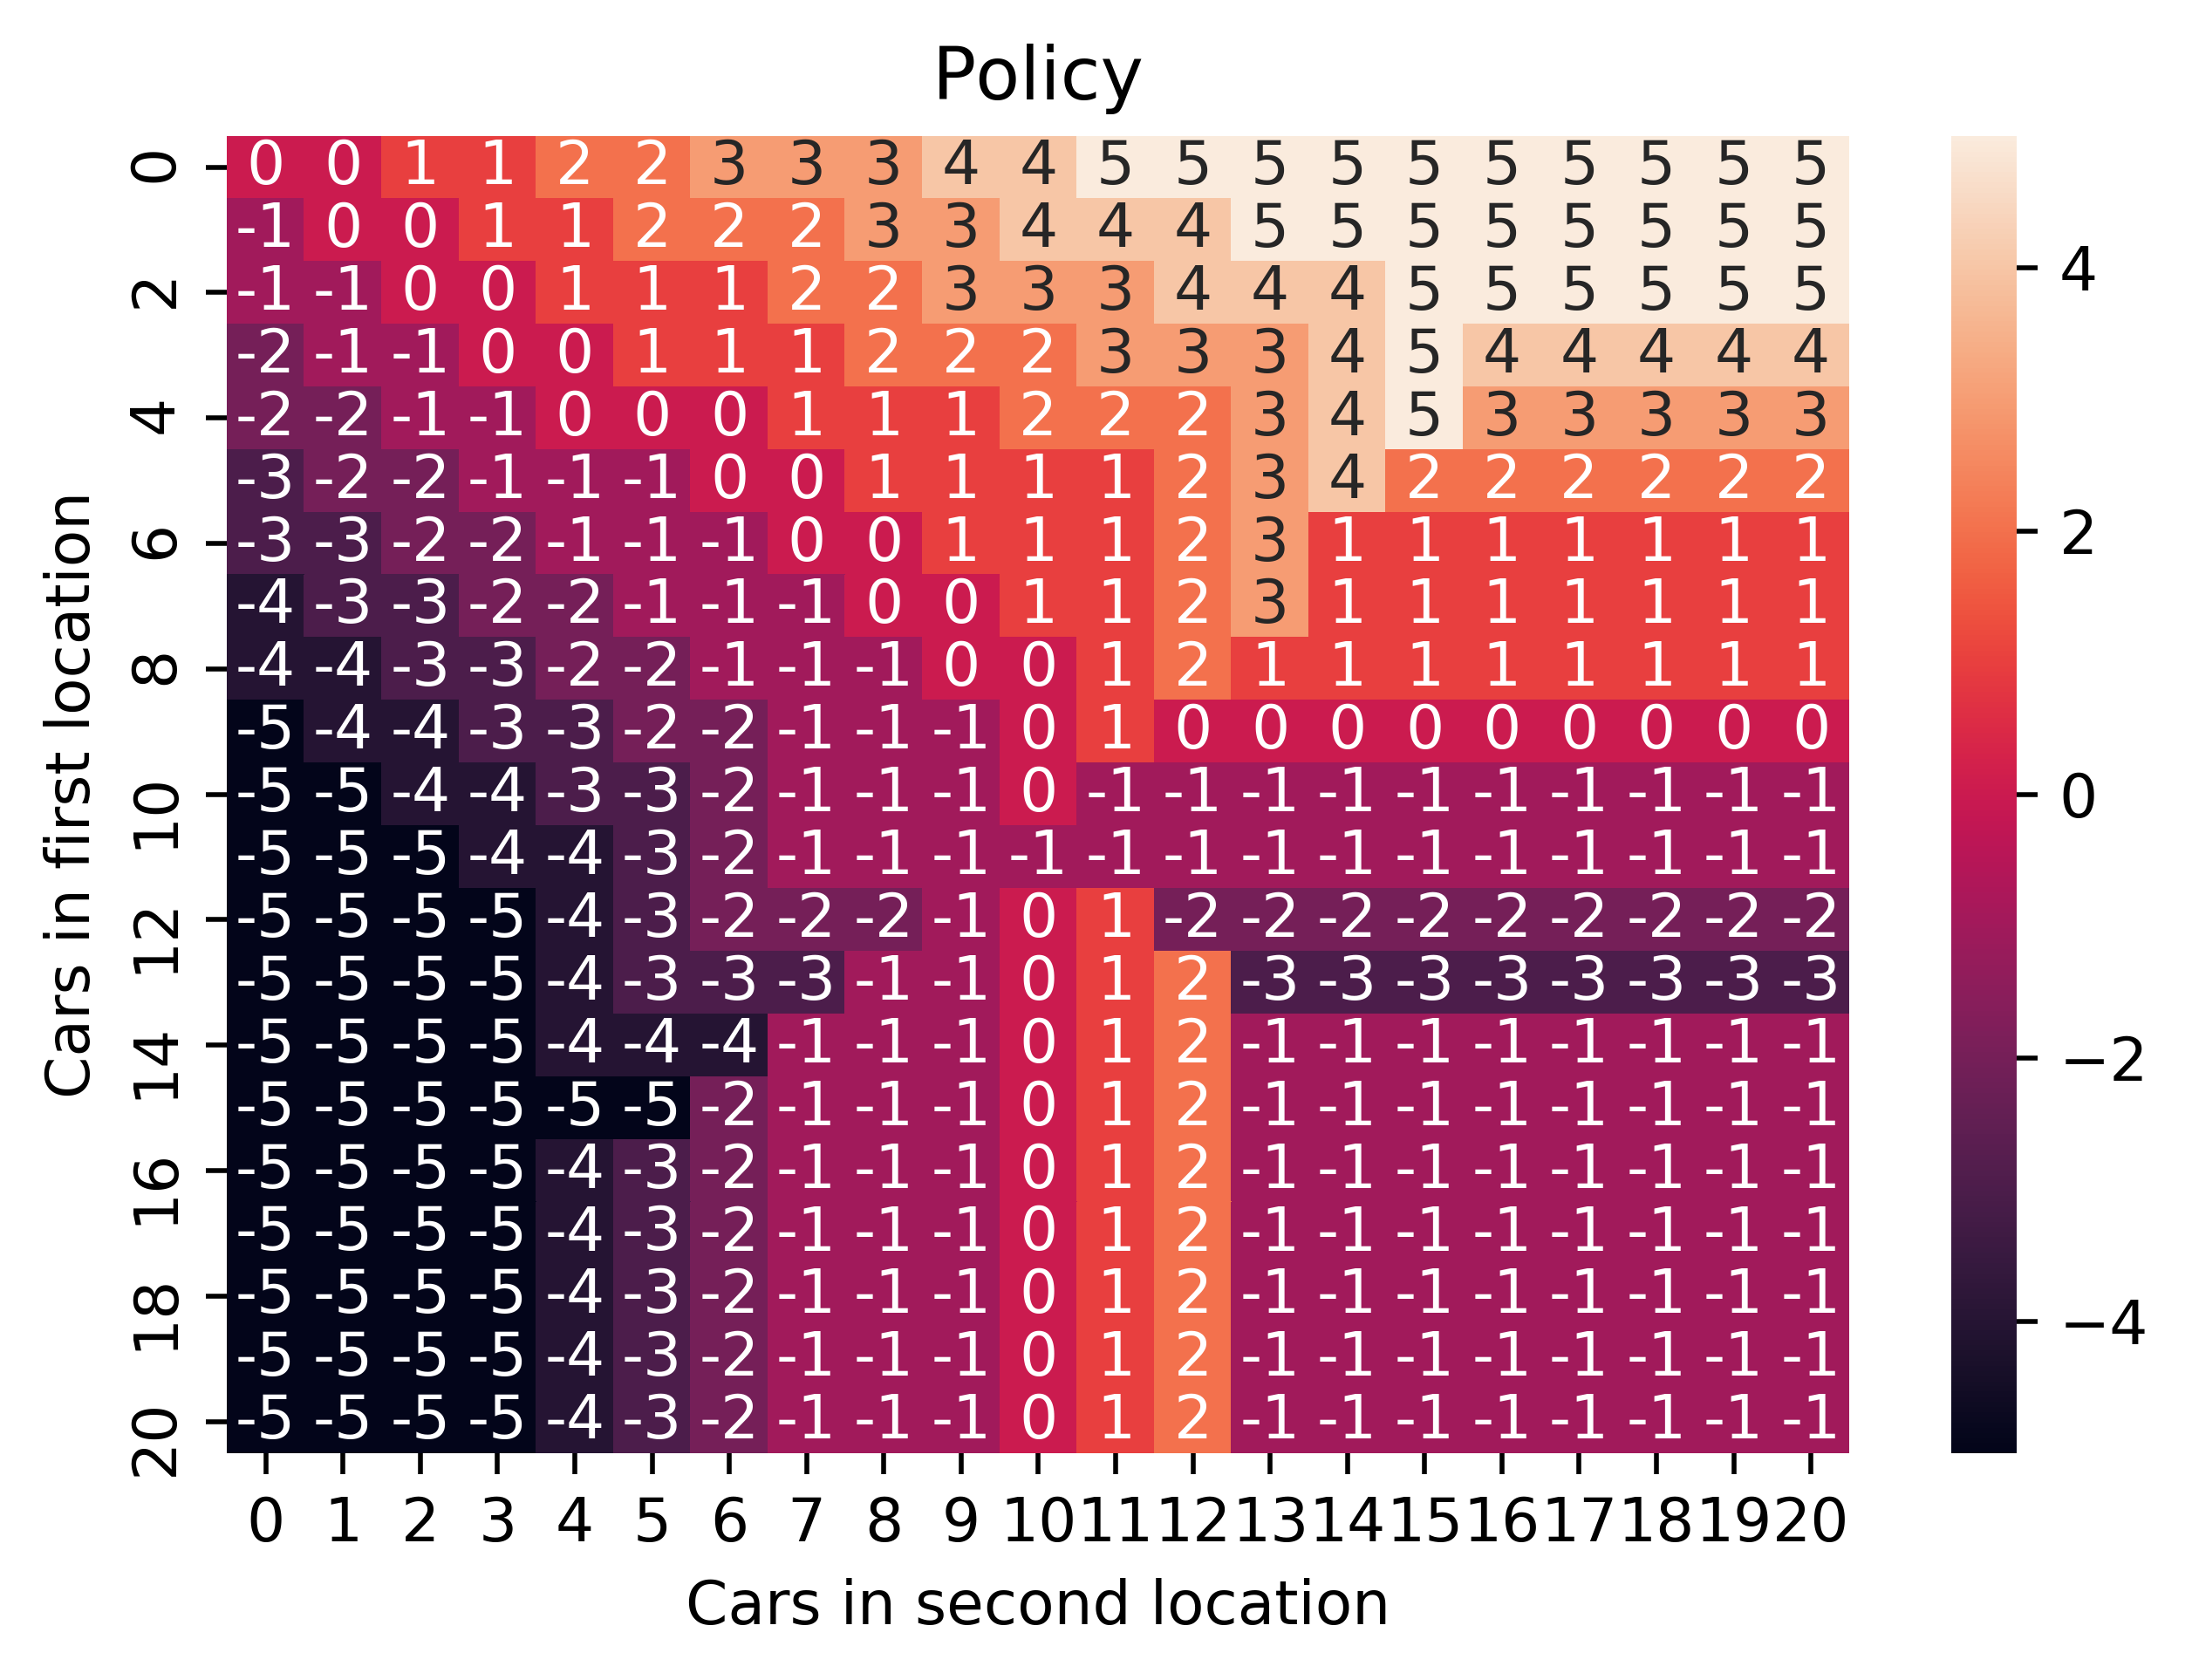

In [24]:
plt.subplots(dpi = 500)
sns.heatmap(pi, annot = True)
plt.title('Policy')
plt.ylabel('Cars in first location')
plt.xlabel('Cars in second location')
plt.show()

The results are surprisingly interesting. First of all, for values above 13 for both locations simultaneously, the optimal seems to be -1. But in fact, is a triple tie between -1, 0 and 1. Indeed, moving 1, 0 or -1 costs the same (0) and is not going to have an effect because there is not such high demand anyway. 
Also, if we look only to the second location (x axis) we can see a mysterious 1 and 2 columns at 11 and 12 for values of y above 12. This has a very specific explanation. It is that if we have more than ten in one place and more than one in the other, we could try to reduce one of them because if we have more than 10 cars in a parking we pay 4 units. For 13  it is a tie again to move them or not, as moving them costs the same as the parking fee. 

Logically, if we have few cars in one place we should move some to it, depending on how few there are. 

Many other interesting conclusions can be extracted from the policy.